In [1]:
import networkx as nx, numpy as np, matplotlib.pyplot as plt, re, yaml,sys
from datetime import datetime,date
from collections import defaultdict
from functools import reduce
today = re.sub('-','_',str(date.today()))
today

'2020_04_06'

# Introduction to Regular Expressions

In [2]:
s = %pwd
if not re.search('Downloads$',s):
    %cd Downloads

C:\Users\nlgun\Downloads


In [3]:
quotere = '''["']'''
quoted_term_re = quotere + '(\w[\w \-]*\w)\W?' + quotere # all quoted terms
quoted_term_re_mod = quotere + '\w[\w \-]*\W?' + quotere # all quoted terms
start_definition_re = '^\s*([Tt]he|[Aa])? *(' + quoted_term_re + ')'#formal definition at a line's beginning
#altdefinition_re =  quotere + '?([\w\s\-]+)' + quotere + '?\.\.\.+' # works with findall to get the defined term
altdefinition_re =  '([\w \-]+\w)' + ' *\.\.\.+' # works with findall to get the defined term
altdefinitionsplit_re =  '[\w \-]+\.\.\.+ *' # for splitting
quoted_term_re

'["\'](\\w[\\w \\-]*\\w)\\W?["\']'

In [4]:
re.search(quotere,"'")

<_sre.SRE_Match object; span=(0, 1), match="'">

In [5]:
re.search(quoted_term_re,'"Senior Reduction Amount"')

<_sre.SRE_Match object; span=(0, 25), match='"Senior Reduction Amount"'>

# Some useful functions

## Basic functions of general use

In [6]:
def partition(l,f):
    a,b = [],[]
    for e in l: (a if f(e) else b).append(e)
    return a,b
compact = lambda l: [e for e in l if e]
get_words = lambda s: re.split('[^\w\-]',s)
numwords = lambda s: len(get_words(s))
initcap = lambda w: w[0] and w[0] == w[0].upper()
def icappc(s):
    wds = compact(get_words(s))
    total = len(wds)
    if total > 0: 
        up,low = partition(wds,initcap)
        return float(len(up))/total

test_initial_capitals_in_term = lambda x: x.strip() and icappc(x.strip()) > 0.9
get_all_defined_terms = lambda regex: lambda s:list(filter(test_initial_capitals_in_term,re.findall(regex,s)))
get_all_quoted_terms = get_all_defined_terms(quoted_term_re)

# a convenience function to identify True object values
idty = lambda x: x

def sentence_split(s):
    parts = re.split('(\.)\s+([A-Z1-9])',s)
    seglength = 3
    lastInitial,ar,seglenth = '',[],2
    for i in range(0,len(parts)- seglength,seglength):
        currentparts = parts[i:i+seglength]
        current = ''.join(currentparts[:seglenth])
        if lastInitial: current = lastInitial + current
        ar.append(current)
        lastInitial = currentparts[seglenth]
    ar.append(lastInitial + parts[-1])
    return ar
    #return [reduce(lambda cum,x:cum+s,parts[i:i+seglength]) for i in (0,len(parts),3)]
    #return parts#''.join(parts[0:2]) + [parts[i] + parts[i+1] for i in range(2,len(parts[1:]),2)]
sentence_split('start here. This is one. Here is another. and here a third.')

['start here.', 'This is one.', 'Here is another. and here a third.']

# Sentences

In [7]:
with open('connave-2016-c01-prospectusNLG.txt') as f:
    #lines = f.readlines()#list(filter(lambda x: len(re.split('\W',x.strip())) > 12, f.readlines()))
    ptext_ = f.read()


In [8]:
#ptext = re.sub('''[^\w\."']+''',' ',ptext)
ptext = re.sub('\s+',' ',ptext_)

In [9]:
ptext[100:150]

's Due August 2028 Offered Notes: The Classes of No'

In [10]:
sents = sentence_split(ptext)
sents[100:102] # HERE'S A PROBLEM - THE CODE THINKS "U.S. Department" ends a sentence.

['Securities and Exchange Commission ("SEC") and the U.S.',
 'Department of the Treasury ("Treasury").']

In [13]:
ptext0=ptext # to have permanence

## A simple definition locator

In [14]:
getdef = lambda term,lines=lines: [line for line in lines if re.search(term,line)]

In [15]:
getdef('Securities and Exchange Commission')

['Securities and Exchange Commission ("SEC") and the U.S.']

In [19]:
#rex = '([A-Z\.]+\.)(\s+[A-Z])'
rex = '([A-Z\.]+\.)\s+[A-Z]'
re.findall(rex,"This is an example U.S. Federal Trade.  Here's another")

['U.S.']

In [22]:
i = 0
ar = []
for acro in list(set(re.findall(rex,ptext0))): # for 'acronym'
    #if acro: print(acro)
    war = acro.split('.')
    war = list(filter(idty,war))
    if len(war)> 1: 
        print(acro,war)
        #print(war,acro[0])
        if acro[0] not in ar: 
            ptext0 = re.sub(acro[0],''.join(war),ptext0)
            ar.append(acro[0])
        i+=1
sents = sentence_split(ptext0)
sents[100:102]#,getdef(s,sents)    

['For more information on the risks to our business relating to the conservatorship and uncertainties regarding the future of our company and business, please see "Risk Factors — Risks Relating to Fannie Mae".',
 'In September 2008, we, through FHFA as our conservator, entered into two agreements with Treasury.']

In [23]:
getdef('Securities and Exchange Commission',sents)

['Our regulators also include the US Securities and Exchange Commission ("SEC") and the US Department of the Treasury ("Treasury").']

In [24]:
getdef('"Senior Reduction Amount"',sents),getdef('"Subordinate Reduction Amount"',sents)

(['Related Definitions The "Senior Reduction Amount" with respect to any Payment Date and Loan Group is either: (A) if any of the Minimum Credit Enhancement Test and the Delinquency Test for such Loan Group is not satisfied, the sum of: (i) the Senior Percentage of the Scheduled Principal for such Payment Date and Loan Group; (ii) 100% of the Unscheduled Principal for such Payment Date and Loan Group; and (iii) 100% of the Recovery Principal for such Payment Date and Loan Group; or (B) if the Minimum Credit Enhancement Test and the Delinquency Test for such Loan Group are satisfied, the sum of: (i) the Senior Percentage of the Scheduled Principal for such Payment Date and Loan Group; (ii) the Senior Percentage of the Unscheduled Principal for such Payment Date and Loan Group; and (iii) 100% of the Recovery Principal for such Payment Date and Loan Group.'],
 ['The "Subordinate Reduction Amount" with respect to any Payment Date and Loan Group is the sum of the Scheduled Principal, Unsche

In [102]:
[sent for sent in sents if re.search('"Senior Reduction Amount"',sent)] # CHECK on getdef

['Related Definitions The "Senior Reduction Amount" with respect to any Payment Date and Loan Group is either: (A) if any of the Minimum Credit Enhancement Test and the Delinquency Test for such Loan Group is not satisfied, the sum of: (i) the Senior Percentage of the Scheduled Principal for such Payment Date and Loan Group; (ii) 100% of the Unscheduled Principal for such Payment Date and Loan Group; and (iii) 100% of the Recovery Principal for such Payment Date and Loan Group; or (B) if the Minimum Credit Enhancement Test and the Delinquency Test for such Loan Group are satisfied, the sum of: (i) the Senior Percentage of the Scheduled Principal for such Payment Date and Loan Group; (ii) the Senior Percentage of the Unscheduled Principal for such Payment Date and Loan Group; and (iii) 100% of the Recovery Principal for such Payment Date and Loan Group.']

In [25]:
lines = sents # use this as our definitions

In [26]:
keyterms = 'Senior Reduction Amount;Subordinate Reduction Amount;Payment Date;Closing Date;Group 1 Exchangeable Notes;Eligibility Defect Rate'.split(';')

In [27]:
keyterms

['Senior Reduction Amount',
 'Subordinate Reduction Amount',
 'Payment Date',
 'Closing Date',
 'Group 1 Exchangeable Notes',
 'Eligibility Defect Rate']

# Testing objects

In [28]:
class Tester(object):
    def __init__(self):
        self.tests = []
    def append(self,newtest):
        self.tests.append(newtest)
    def get_test_results(self,x):
        return [test(x) for test in self.tests]
    def test(self,x):
        return all(self.get_test_results(x))
    def test_or(self,x): # alternative that tests with or
        return any(self.get_test_results(x))
    
# a word tester
wordtester = Tester()
wordtester.append(lambda word: word and word[0]==word[0].upper())
wordtester.append(lambda word: word and (len(word)==1 or word[-1]==word[-1].lower()))
assert wordtester.test('class')==False and wordtester.test('Class') == True
# a word list tester
definedtermtester = Tester()
definedtermtester.append(lambda definedterm: not(len(definedterm)==1 and definedterm[0][1]==definedterm[0][1].upper()))
definedtermtester.append(lambda definedterm: definedterm[0][0] > 0 or len(definedterm) > 1)
definedtermtester.test([(0, 'Start')])
definedtermtester.tests[0]([(2, 'One'), (3, '1'), (4, 'Defined'), (5, 'definedterm')])

True

In [29]:
def clean(term):
    words = term.split()
    while words:
        word = words.pop(0)
        if word[0] == word[0].upper(): 
            words.insert(0,word)
            break
    cleanterm = ' '.join(words)
    return re.sub('^\d+|^The','',cleanterm).strip()
print(clean('and this is The Real Definition not the false one'))
test = lambda x: test_initial_capitals_in_term(x) and len(x.split('\W'))< 10 and len(re.findall('\W',x))<4

Real Definition not the false one


# Extracting from Sentences and Longer Strings

In [30]:
# testsentencefirstword checks if the defined term starts the sentence
# if so, since the first word capitalized to start a sentence a one word
# definedterm would not necessarily be a defined term
testsentencefirstword = definedtermtester.test

class SentenceExtracter(object):
    
    @classmethod
    def defined_terms(kls,s=''):
        stester = SentenceExtracter(wordtester)
        if s: 
            sents = sentence_split(s)
            return([term for sent in sents for term in stester.get_defined_terms(sent,1)],stester)
        else: return stester
        
    def __init__(self,wordtester,splitter = get_words,testerm = testsentencefirstword):
        self.splitter = splitter
        self.wordtester = wordtester
        self.testterm = testerm
    
    # default splitter
    def split(self,s): return self.splitter(s)
      
    def get_defined_term_list(self,s):
        self.defined_term_ar = []
        definedterm = []
        words = self.split(s)
        for i, word in enumerate(words):
            if self.wordtester.test(word): definedterm.append((i,word))
            else:
                #print('candidate defined term',definedterm)
                if definedterm:
                    # discard initial capitalization - should this happen first?
                    if self.testterm(definedterm):
                        self.defined_term_ar.append(definedterm)
                    definedterm = []
                    firstword = False
        # after loop, check if a final defined term must be added
        if definedterm:
            self.defined_term_ar.append(definedterm)
    
    def get_defined_terms(self,s,rtn=False):
        self.get_defined_term_list(s)
        self.definedterms = [' '.join([t for i,t in term]) for term in self.defined_term_ar]
        if rtn: return self.definedterms
s = 'Start with One 1 Defined Term and add Another Defined Term'
stester = SentenceExtracter(wordtester)
stester.get_defined_term_list(s)
#print(stester.defined_term_ar)
#print('defined terms',stester.get_defined_terms(s,1))
assert stester.get_defined_terms(s,1) == ['One 1 Defined Term', 'Another Defined Term']

## A crude search for an interesting line to test

In [31]:
aa = [line for line in lines if re.search('"Subordinate Reduction Amount"',line)]
aa

['The "Subordinate Reduction Amount" with respect to any Payment Date and Loan Group is the sum of the Scheduled Principal, Unscheduled Principal and Recovery Principal for such Payment Date and Loan Group, less the Senior Reduction Amount for such Loan Group.']

In [32]:
set(SentenceExtracter.defined_terms(aa[0])[0])

{'Loan Group',
 'Payment Date',
 'Recovery Principal',
 'Scheduled Principal',
 'Senior Reduction Amount',
 'Subordinate Reduction Amount',
 'Unscheduled Principal'}

In [33]:
# test an enumerator
next(enumerate(range(1,4)))

(0, 1)

In [34]:
get_numbered_lines = lambda rex: [(i,line) for i,line in enumerate(lines) if re.search(rex,line)]

## Example of a challenging defined term from the terms sheet portion

In [35]:
targetlines = get_numbered_lines('Interest Only RCR Notes\s*\.{4,}')

In [36]:
len(targetlines),targetlines[0] # check against the prospectus

(2,
 (550,
  'Class Notional Amount of The Class 1M-2I Notes are not entitled to receive Interest Only RCR Notes...................................... payments of principal.'))

# Get Defined Terms

In [37]:
class Selector(object):
    
    def __init__(self,itr,regex,proc=False,testterm = None):
        self.itr = itr # lines
        self.regex = regex #lead regular expression
        #print(self.regex)
        self.testterm = testterm or (lambda x: True)
        self.term_definitions = []
        if proc: self.proclines()
            
    def proclines(self): # processes all lines
        # only accumulate where the procline return is True
        # print("processing lines")
        self.term_definitions = []
        for line in self.itr:
            processed_line = self.procline(line)
            if not processed_line: continue
            term,definition = processed_line
            if term: self.proc_terms_definition(term,definition)
            #= [(term,definition) for terms,definition in term_definitions_ for term in terms if terms and term and self.testterm(term)]
    
    def procline(self,line):
        term,definition = (self.get_term(line),self.get_definition(line))
        return (term,definition) if term else None

    def get_term(self,line):
        result = list((e for e in (term.strip() for term in re.findall(self.regex,line)) if e))
        return result
    
    def get_definition(self,line):
        return line
    
    def term2key(self,term):
        term = re.sub('^[\d\s\W]+','',term)
        return (re.sub('^The\s*','',term)).strip()
    
    def proc_terms_definition(self,terms,definition): # particular to using findall which returns a list of terms
        for term in terms:
            assert isinstance(term,str)
            assert len(term.strip()) > 0, 'problems with term %s\n and %s\n\n in line %s' %(term,definition,line)
            if self.testterm(term): self.term_definitions.append((self.term2key(term),definition))

In [40]:
class Selector_e(Selector):# handles enumerated lines
    
     def get_term(self,line):
        result = list((e for e in (term.strip() for term in re.findall(self.regex,line[1])) if e))
        return result

In [41]:
# a convenience function for adding to a defaultdict
add_def = lambda k,v,d: d[k].append(v) # d is a defaultdict(list)

def list2dict(tuplelist):
    resdict = defaultdict(list) # result dictionary
    for key,definition in tuplelist:
        if len(key) > 5 and icappc(key)> 0.8: resdict[re.sub('^\s*\W*\s*','',key.strip())].append(definition)
    return resdict

## Testing Selector

In [42]:
# another test
s = getdef('"Payment Date"')
re.findall(quoted_term_re,s[1]),s[1]

(['Payment Date', 'Record Date'],
 'Payments Payments on the Notes will be made by the Global Agent, as paying agent, on the twenty-fifth (25th) day of each month (or, if such day is not a Business Day, then on the next succeeding Business Day), beginning in March 2016 (each, a "Payment Date"), to the persons in whose names such Notes are registered as of the close of business on the immediately preceding Business Day in the case of Book-Entry Notes and as of the close of business on the last day of the preceding month of such Payment Date in the case of Definitive Notes (the "Record Date").')

## A simple example

In [43]:
q = Selector_e(enumerate([s[1]]),quoted_term_re,proc=1,testterm = lambda x: True)

In [44]:
q.term_definitions

[('Payment Date',
  (0,
   'Payments Payments on the Notes will be made by the Global Agent, as paying agent, on the twenty-fifth (25th) day of each month (or, if such day is not a Business Day, then on the next succeeding Business Day), beginning in March 2016 (each, a "Payment Date"), to the persons in whose names such Notes are registered as of the close of business on the immediately preceding Business Day in the case of Book-Entry Notes and as of the close of business on the last day of the preceding month of such Payment Date in the case of Definitive Notes (the "Record Date").')),
 ('Record Date',
  (0,
   'Payments Payments on the Notes will be made by the Global Agent, as paying agent, on the twenty-fifth (25th) day of each month (or, if such day is not a Business Day, then on the next succeeding Business Day), beginning in March 2016 (each, a "Payment Date"), to the persons in whose names such Notes are registered as of the close of business on the immediately preceding Busin

## The Prospectus

In [ ]:
testsel = Selector_e(enumerate(lines),quoted_term_re,proc=1,testterm=test)

## Making a Term Dictionary

In [91]:
termdict  =  list2dict(testsel.term_definitions)
print(len(lines),len([e for e in testsel.term_definitions]))

4026 331


In [46]:
termdict['Senior Reduction Amount']

[(1804,
  'Related Definitions The "Senior Reduction Amount" with respect to any Payment Date and Loan Group is either: (A) if any of the Minimum Credit Enhancement Test and the Delinquency Test for such Loan Group is not satisfied, the sum of: (i) the Senior Percentage of the Scheduled Principal for such Payment Date and Loan Group; (ii) 100% of the Unscheduled Principal for such Payment Date and Loan Group; and (iii) 100% of the Recovery Principal for such Payment Date and Loan Group; or (B) if the Minimum Credit Enhancement Test and the Delinquency Test for such Loan Group are satisfied, the sum of: (i) the Senior Percentage of the Scheduled Principal for such Payment Date and Loan Group; (ii) the Senior Percentage of the Unscheduled Principal for such Payment Date and Loan Group; and (iii) 100% of the Recovery Principal for such Payment Date and Loan Group.')]

In [47]:
getdef('"Senior Reduction Amount"')

['Related Definitions The "Senior Reduction Amount" with respect to any Payment Date and Loan Group is either: (A) if any of the Minimum Credit Enhancement Test and the Delinquency Test for such Loan Group is not satisfied, the sum of: (i) the Senior Percentage of the Scheduled Principal for such Payment Date and Loan Group; (ii) 100% of the Unscheduled Principal for such Payment Date and Loan Group; and (iii) 100% of the Recovery Principal for such Payment Date and Loan Group; or (B) if the Minimum Credit Enhancement Test and the Delinquency Test for such Loan Group are satisfied, the sum of: (i) the Senior Percentage of the Scheduled Principal for such Payment Date and Loan Group; (ii) the Senior Percentage of the Unscheduled Principal for such Payment Date and Loan Group; and (iii) 100% of the Recovery Principal for such Payment Date and Loan Group.']

In [48]:
# test that we captured all the keyterms
for kt in keyterms:
    print(kt in termdict)

True
True
True
True
True
True


In [99]:
termdict['Payment Date'] # take a look at some definition(s)

[(555,
  'Payments on the Notes will be made by the Global Agent on the twenty-fifth (25th) day of each month (or, if such day is not a Business Day, then on the next succeeding Business Day) beginning in March 2016 (each, a "Payment Date").'),
 (1710,
  'Payments Payments on the Notes will be made by the Global Agent, as paying agent, on the twenty-fifth (25th) day of each month (or, if such day is not a Business Day, then on the next succeeding Business Day), beginning in March 2016 (each, a "Payment Date"), to the persons in whose names such Notes are registered as of the close of business on the immediately preceding Business Day in the case of Book-Entry Notes and as of the close of business on the last day of the preceding month of such Payment Date in the case of Definitive Notes (the "Record Date").')]

In [126]:
# compare a more direct method
[e for e in testsel.term_definitions if e[0]=='Payment Date']

[('Payment Date',
  (554,
   'Payments on the Notes will be made by the Global Agent on the twenty-fifth (25th) day of each month (or, if such day is not a Business Day, then on the next succeeding Business Day) beginning in March 2016 (each, a "Payment Date").')),
 ('Payment Date',
  (1705,
   'Payments Payments on the Notes will be made by the Global Agent, as paying agent, on the twenty-fifth (25th) day of each month (or, if such day is not a Business Day, then on the next succeeding Business Day), beginning in March 2016 (each, a "Payment Date"), to the persons in whose names such Notes are registered as of the close of business on the immediately preceding Business Day in the case of Book-Entry Notes and as of the close of business on the last day of the preceding month of such Payment Date in the case of Definitive Notes (the "Record Date").'))]

# Terms Sheet Terms

## A simple terms sheet parser

In [65]:
termsheetre = '( *\w[\w\- ]+\w *)\.{5,}( *\w[\w\- ]+\w *)'# note the spaces, which are more specific than whitespace \s

termsheet_splitre = '( *\w[\w\- ]+\w *)\.{5,}'
termsheetlines = []
remaininglines = []
for i,line in enumerate(lines):
    matches = re.findall(termsheetre,line)
    if matches:
        #print(matches)
        for a,b in matches:
            if test(a): termsheetlines.append((clean(a.strip()),(i,b.strip())))
    else: remaininglines.append((i,line))
len(termsheetlines),len(remaininglines)

(24, 3997)

In [66]:
termsheetlines_f = [(a,b) for a,b in termsheetlines if a and all([wordtester.test(w) for w in a.split()]) and definedtermtester.test(list(enumerate(a.split())))]

In [67]:
[e for e in termsheetlines_f if e[0] == 'Payment Date']

[]

In [69]:
termsheetlines

[('POTENTIAL RECEIVERSHIP', (163, 'iii IMPORTANT NOTICE REGARDING THE NOTES')),
 ('', (2816, '0 0 0 0 0 0 0 0 WAL')),
 ('', (2831, '0 0 0 0 0 0 0 0 WAL')),
 ('', (2846, '0 0 0 0 0 0 0 0 WAL')),
 ('', (2863, '0 0 0 0 0 0 0 0 WAL')),
 ('', (2878, '0 0 0 0 0 0 0 0 WAL')),
 ('', (2894, '0 0 0 0 0 0 0 0 WAL')),
 ('', (2909, '0 0 0 0 0 0 0 0 WAL')),
 ('', (2924, '0 0 0 0 0 0 0 0 WAL')),
 ('', (2939, '0 0 0 0 0 0 0 0 WAL')),
 ('Additional Supplements', (3676, 'x Annual Interest Amount')),
 ('Automatic Termination', (3682, 'iv Available Loans')),
 ('Charter Act', (3692, 'v Citigroup')),
 ('Conservator', (3707, 'iii contingent NPCs')),
 ('FHFA', (3754, 'iii FIEA')),
 ('Freddie Mac', (3756, 'v FSCMA')),
 ('GAAP', (3759, 'vi Garn')),
 ('HUD', (3806, 'v ICE')),
 ('Incorporated Documents', (3808, 'x Indirect Participants')),
 ('Prospectus Directive', (3894, 'viii QC')),
 ('REFORM ACT', (3906, 'iii REIT')),
 ('SEC', (3925, 'v Securities Act')),
 ('Treasury', (3940, 'v US Person')),
 ('Warrant', (394

In [68]:
tsdict = list2dict(termsheetlines_f)

In [92]:
len(remaininglines),len(termsheetlines),len(tsdict)

(3997, 24, 7)

In [60]:
#testsel = Selector_e(remaininglines,quoted_term_re,proc=1,testterm=test)
#termdict  =  list2dict(testsel.term_definitions)

In [93]:
tsdict['Payment Date'],tsdict.keys()

([],
 dict_keys(['Additional Supplements', 'Automatic Termination', 'Charter Act', 'Freddie Mac', 'Incorporated Documents', 'Prospectus Directive', 'Payment Date']))

In [72]:
termdict['Payment Date']

([(555,
   'Payments on the Notes will be made by the Global Agent on the twenty-fifth (25th) day of each month (or, if such day is not a Business Day, then on the next succeeding Business Day) beginning in March 2016 (each, a "Payment Date").'),
  (1710,
   'Payments Payments on the Notes will be made by the Global Agent, as paying agent, on the twenty-fifth (25th) day of each month (or, if such day is not a Business Day, then on the next succeeding Business Day), beginning in March 2016 (each, a "Payment Date"), to the persons in whose names such Notes are registered as of the close of business on the immediately preceding Business Day in the case of Book-Entry Notes and as of the close of business on the last day of the preceding month of such Payment Date in the case of Definitive Notes (the "Record Date").')],
 '--',
 [])

In [73]:
lines[1900]

'The Holders of not less than 50% of the outstanding Class Principal Balance of each Class of Notes to which an Event of Default relates (with the outstanding Class Principal Balances of the Exchangeable Notes to be determined without regard to any exchanges for RCR Notes) may waive, rescind or annul such Event of Default as it relates to such Class at any time.'

In [94]:
#alltermdict = defaultdict(list)
#for k,v in termdict.items():
#    alltermdict[k] = v + tsdict[k] if k in tsdict else v
alltermdict = termdict

In [95]:
[(k,alltermdict[k]) for k in keyterms]

[('Senior Reduction Amount',
  [(1804,
    'Related Definitions The "Senior Reduction Amount" with respect to any Payment Date and Loan Group is either: (A) if any of the Minimum Credit Enhancement Test and the Delinquency Test for such Loan Group is not satisfied, the sum of: (i) the Senior Percentage of the Scheduled Principal for such Payment Date and Loan Group; (ii) 100% of the Unscheduled Principal for such Payment Date and Loan Group; and (iii) 100% of the Recovery Principal for such Payment Date and Loan Group; or (B) if the Minimum Credit Enhancement Test and the Delinquency Test for such Loan Group are satisfied, the sum of: (i) the Senior Percentage of the Scheduled Principal for such Payment Date and Loan Group; (ii) the Senior Percentage of the Unscheduled Principal for such Payment Date and Loan Group; and (iii) 100% of the Recovery Principal for such Payment Date and Loan Group.')]),
 ('Subordinate Reduction Amount',
  [(1805,
    'The "Subordinate Reduction Amount" with

## Add lines through human intervention

In [76]:
list(range(10))[slice(0,2,None)]

[0, 1]

In [96]:
class Lines(object): # a class to facilitate getting ranges of liens
    
    def __init__(self,lines):
        self.lines = lines
        
    def __getitem__(self,rng):
        assert isinstance(rng,tuple), "There must be a tuple of arguments, not  %s" % str(rng)
        assert len(rng)> 1, 'The range %s must have at least a line and a number of subsequent lines' % str(rng)
        a,b = rng[:2]
        c = rng[2] if len(rng) > 2 else 0
        return list(zip(range(a-c,a+b),self.lines[a-c:a+b]))

In [100]:
lines_=Lines(lines)
lines_[1804,6],'-'*20,lines_[1804,6,2]

([(1804,
   'Related Definitions The "Senior Reduction Amount" with respect to any Payment Date and Loan Group is either: (A) if any of the Minimum Credit Enhancement Test and the Delinquency Test for such Loan Group is not satisfied, the sum of: (i) the Senior Percentage of the Scheduled Principal for such Payment Date and Loan Group; (ii) 100% of the Unscheduled Principal for such Payment Date and Loan Group; and (iii) 100% of the Recovery Principal for such Payment Date and Loan Group; or (B) if the Minimum Credit Enhancement Test and the Delinquency Test for such Loan Group are satisfied, the sum of: (i) the Senior Percentage of the Scheduled Principal for such Payment Date and Loan Group; (ii) the Senior Percentage of the Unscheduled Principal for such Payment Date and Loan Group; and (iii) 100% of the Recovery Principal for such Payment Date and Loan Group.'),
  (1805,
   'The "Subordinate Reduction Amount" with respect to any Payment Date and Loan Group is the sum of the Schedul

In [98]:
alltermdict['Senior Reduction Amount']

[(1804,
  'Related Definitions The "Senior Reduction Amount" with respect to any Payment Date and Loan Group is either: (A) if any of the Minimum Credit Enhancement Test and the Delinquency Test for such Loan Group is not satisfied, the sum of: (i) the Senior Percentage of the Scheduled Principal for such Payment Date and Loan Group; (ii) 100% of the Unscheduled Principal for such Payment Date and Loan Group; and (iii) 100% of the Recovery Principal for such Payment Date and Loan Group; or (B) if the Minimum Credit Enhancement Test and the Delinquency Test for such Loan Group are satisfied, the sum of: (i) the Senior Percentage of the Scheduled Principal for such Payment Date and Loan Group; (ii) the Senior Percentage of the Unscheduled Principal for such Payment Date and Loan Group; and (iii) 100% of the Recovery Principal for such Payment Date and Loan Group.')]

In [101]:
print([k in alltermdict.keys() for k in keyterms + ['Loan Group']])

[True, True, True, True, True, True, False]


## Finding Keys Approximately

In [89]:
rexget_dict = lambda d,rex: [k for k in d.keys() if re.search(rex,k)]

In [90]:
loangroupks = rexget_dict(alltermdict,'Loan Group')
loangroupks,[alltermdict[k] for k in loangroupks]

(['Loan Groups', 'Loan Group 1', 'Loan Group 2'],
 [[(417, 'The Reference Pool will be divided into two "Loan Groups".')],
  [(418,
    'The Group 1 Notes are structured so that (i) interest is paid directly by us and (ii) principal is paid by us relative to the principal payments and performance of a group of Reference Obligations ("Loan Group 1"), with an initial aggregate unpaid principal balance as of the Cutoff Date of approximately \\n\\n18,999,684,441 (the "Loan Group 1 Cut-off Date Balance").')],
  [(419,
    'The Group 2 Notes are structured so that (i) interest is paid directly by us and (ii) principal is paid by us relative to the principal payments and performance of a group of Reference Obligations ("Loan Group 2"), with an initial aggregate unpaid principal balance as of the Cut-off Date of approximately \\n\\n10,827,710,232 (the "Loan Group 2 Cut-off Date Balance").')]])

In [102]:
alltermdict['Senior Reduction Amount']

[(1804,
  'Related Definitions The "Senior Reduction Amount" with respect to any Payment Date and Loan Group is either: (A) if any of the Minimum Credit Enhancement Test and the Delinquency Test for such Loan Group is not satisfied, the sum of: (i) the Senior Percentage of the Scheduled Principal for such Payment Date and Loan Group; (ii) 100% of the Unscheduled Principal for such Payment Date and Loan Group; and (iii) 100% of the Recovery Principal for such Payment Date and Loan Group; or (B) if the Minimum Credit Enhancement Test and the Delinquency Test for such Loan Group are satisfied, the sum of: (i) the Senior Percentage of the Scheduled Principal for such Payment Date and Loan Group; (ii) the Senior Percentage of the Unscheduled Principal for such Payment Date and Loan Group; and (iii) 100% of the Recovery Principal for such Payment Date and Loan Group.')]

# Modifying AllTermDict Manually

## Example - Credit Event

In [103]:
alltermdict['Credit Event']

[(1532,
  'Fannie Mae May Amend the Transaction Documents to Limit Disposition Alternatives We may amend the transaction agreements at any time to provide either (x) that the mortgage note sales referred to in clause (iv) of the definition of "Credit Event" will thereafter be prohibited with respect to the Reference Obligations or (y) that such mortgage note sales will thereafter be treated as Reference Pool Removals rather than as Credit Events.'),
 (1825,
  'Related Definitions A "Credit Event" with respect to any Payment Date on or before the related Group Termination Date and any Reference Obligation is the first to occur of any of the following events during the related Reporting Period, as reported by the servicer to Fannie Mae, if applicable: (i) a short sale is settled, (ii) the related mortgaged property is sold to a third party during the foreclosure process, (iii) an REO disposition occurs, (iv) a mortgage note sale is executed on a seriously delinquent loan prior to foreclo

In [104]:
alltermdict['Credit Event'] = alltermdict['Credit Event'][1:2]
alltermdict['Credit Event']

[(1825,
  'Related Definitions A "Credit Event" with respect to any Payment Date on or before the related Group Termination Date and any Reference Obligation is the first to occur of any of the following events during the related Reporting Period, as reported by the servicer to Fannie Mae, if applicable: (i) a short sale is settled, (ii) the related mortgaged property is sold to a third party during the foreclosure process, (iii) an REO disposition occurs, (iv) a mortgage note sale is executed on a seriously delinquent loan prior to foreclosure or (v) the related mortgage note is charged off.')]

# Making a Graph

In [105]:
g = nx.DiGraph()

In [106]:
edges = []
for k,v in alltermdict.items():
    for k1 in alltermdict.keys():
        if k == k1: continue
        for i,txt in v:
            if re.search(k1,txt):
                edges.append((k1,k))

In [107]:
edges_ = list(set(edges))

In [108]:
g.add_edges_from(edges_)

In [109]:
g.in_edges('Subordinate Reduction Amount')

[('Scheduled Principal', 'Subordinate Reduction Amount'),
 ('Recovery Principal', 'Subordinate Reduction Amount'),
 ('Senior Reduction Amount', 'Subordinate Reduction Amount'),
 ('Unscheduled Principal', 'Subordinate Reduction Amount'),
 ('Payment Date', 'Subordinate Reduction Amount')]

In [110]:
g.in_edges('Senior Reduction Amount')

[('Payment Date', 'Senior Reduction Amount'),
 ('Unscheduled Principal', 'Senior Reduction Amount'),
 ('Scheduled Principal', 'Senior Reduction Amount'),
 ('Recovery Principal', 'Senior Reduction Amount'),
 ('Delinquency Test', 'Senior Reduction Amount'),
 ('Minimum Credit Enhancement Test', 'Senior Reduction Amount')]

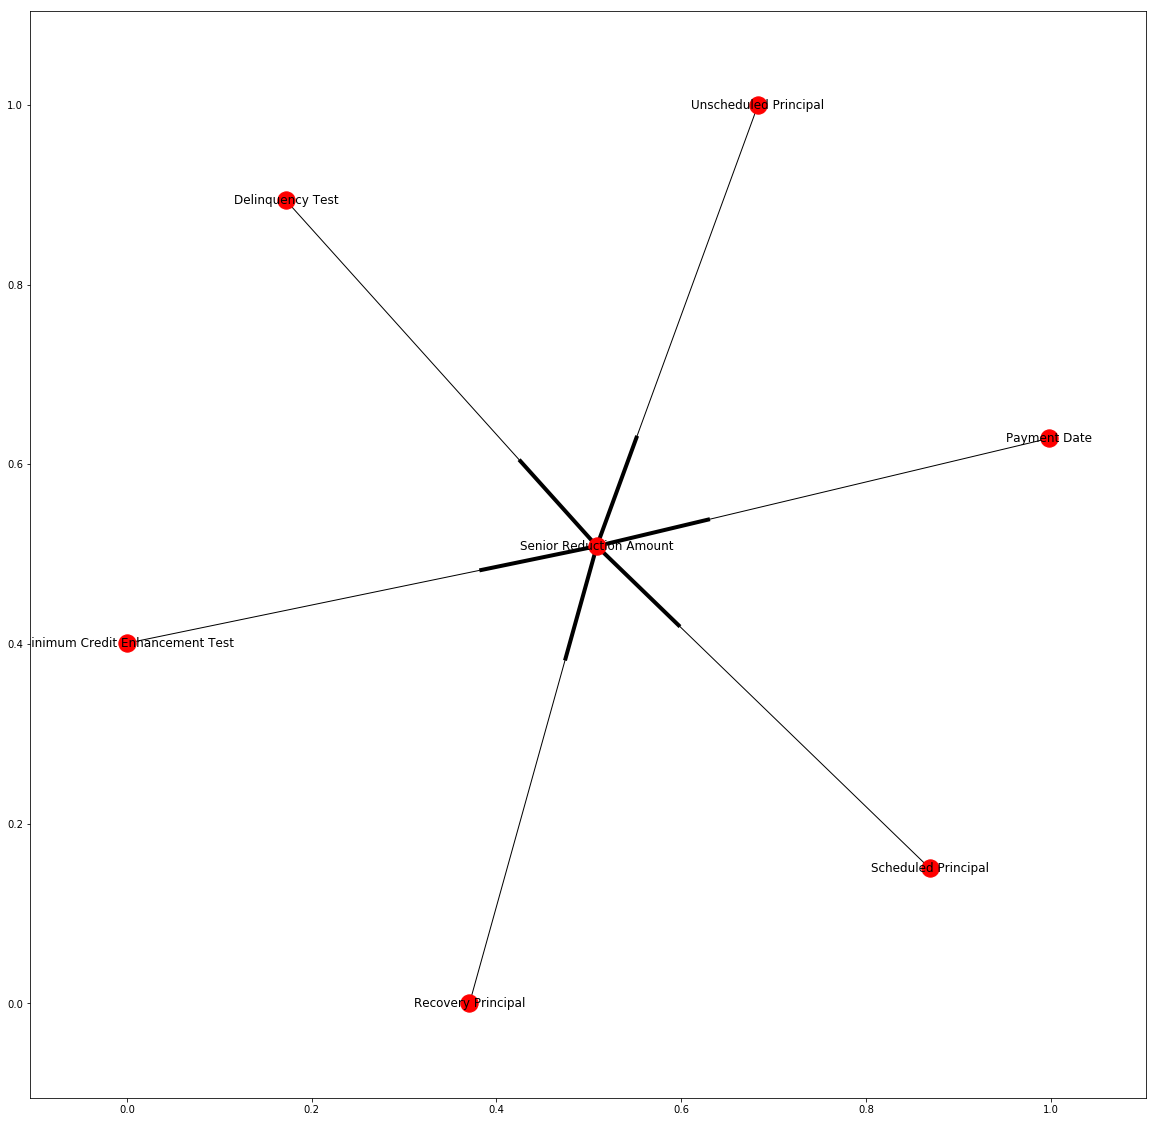

In [111]:
g1 = nx.DiGraph()
g1.add_edges_from(list(g.in_edges('Senior Reduction Amount')))
plt.figure(1,figsize=(20,20))
nx.draw_networkx(g1)
plt.show()

In [120]:
for edge in g.in_edges('Senior Reduction Amount'):
    print('-'*20)
    print(edge[0])
    print(alltermdict[edge[0]])

--------------------
Payment Date
[(555, 'Payments on the Notes will be made by the Global Agent on the twenty-fifth (25th) day of each month (or, if such day is not a Business Day, then on the next succeeding Business Day) beginning in March 2016 (each, a "Payment Date").'), (1710, 'Payments Payments on the Notes will be made by the Global Agent, as paying agent, on the twenty-fifth (25th) day of each month (or, if such day is not a Business Day, then on the next succeeding Business Day), beginning in March 2016 (each, a "Payment Date"), to the persons in whose names such Notes are registered as of the close of business on the immediately preceding Business Day in the case of Book-Entry Notes and as of the close of business on the last day of the preceding month of such Payment Date in the case of Definitive Notes (the "Record Date").')]
--------------------
Unscheduled Principal
[(1811, 'On the Closing Date, the Group 2 Subordinate Percentage will be 4.00%. "Scheduled Principal" with

In [114]:
# newer - based on a graph recursion excluding existing edges and nodes
def traceback(g,n,g_ = nx.DiGraph(),num = 0, it=0):
    #if it == 0: assert not edges
    newedges = list(set([edge for edge in list(g.in_edges(n)) 
                         if  edge not in g_.edges() and edge[0] not in g_.nodes()])).copy()
    if newedges and it < num:
        g_.add_edges_from(newedges)
        for edge in newedges:
            g_ = traceback(g,edge[0],g_,num=num,it=it+1)
    return g_

In [115]:
#g0 = traceback(g.copy(),'Subordinate Reduction Amount',num=3)
g3 = traceback(g.copy(),'Senior Reduction Amount',num=3)
g2 = traceback(g.copy(),'Senior Reduction Amount',num=2)
g1 = traceback(g.copy(),'Senior Reduction Amount',num=1)
#edx1 =traceback(g.copy(),'Senior Reduction Amount',num=2,edges=set([]))

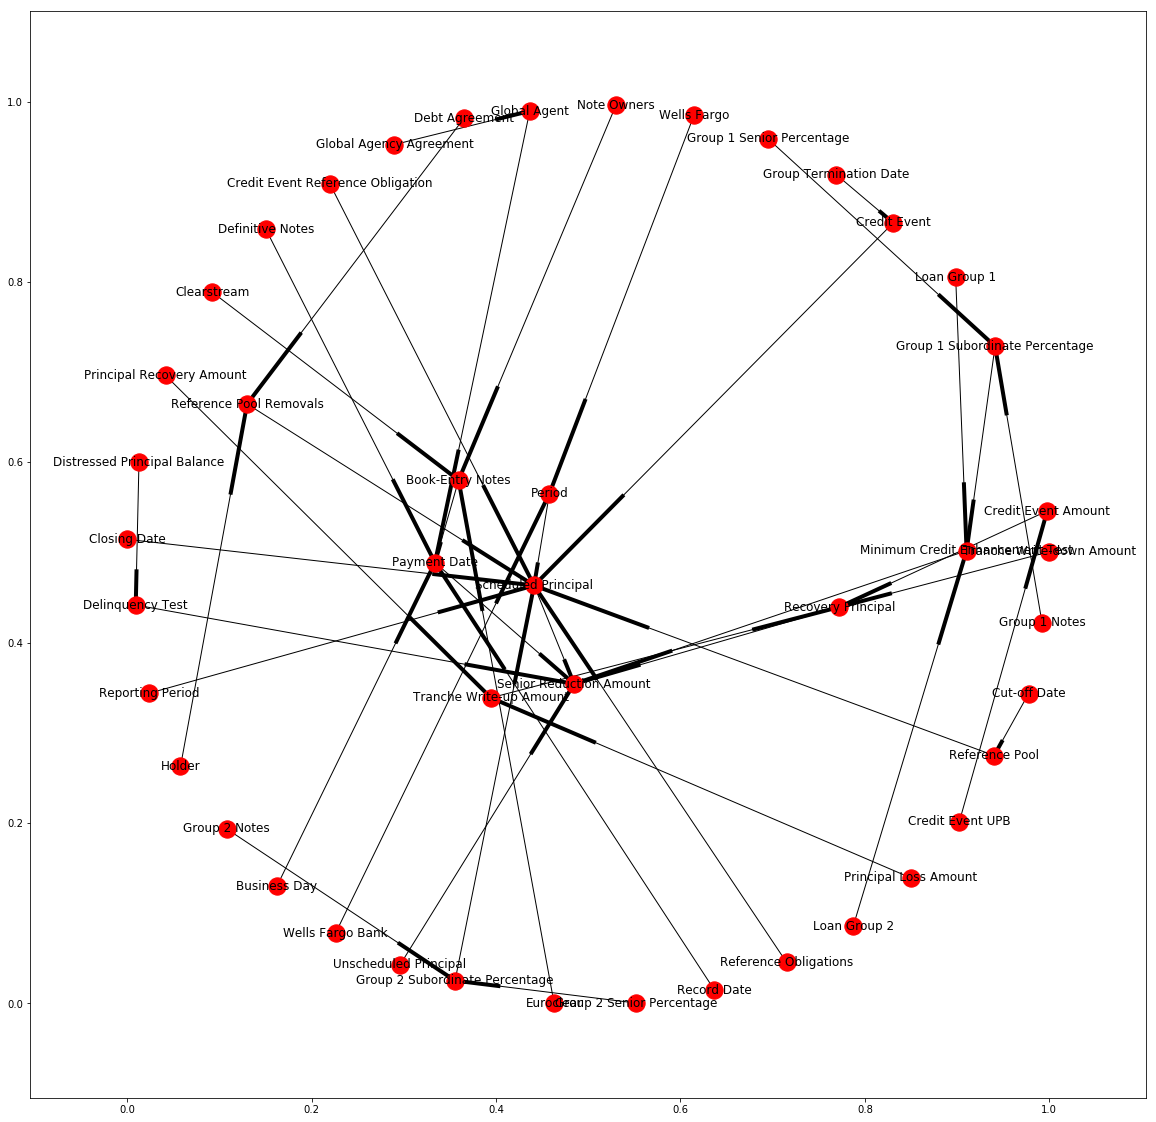

In [116]:
plt.figure(1,figsize=(20,20))
nx.draw_networkx(g3)
plt.show()

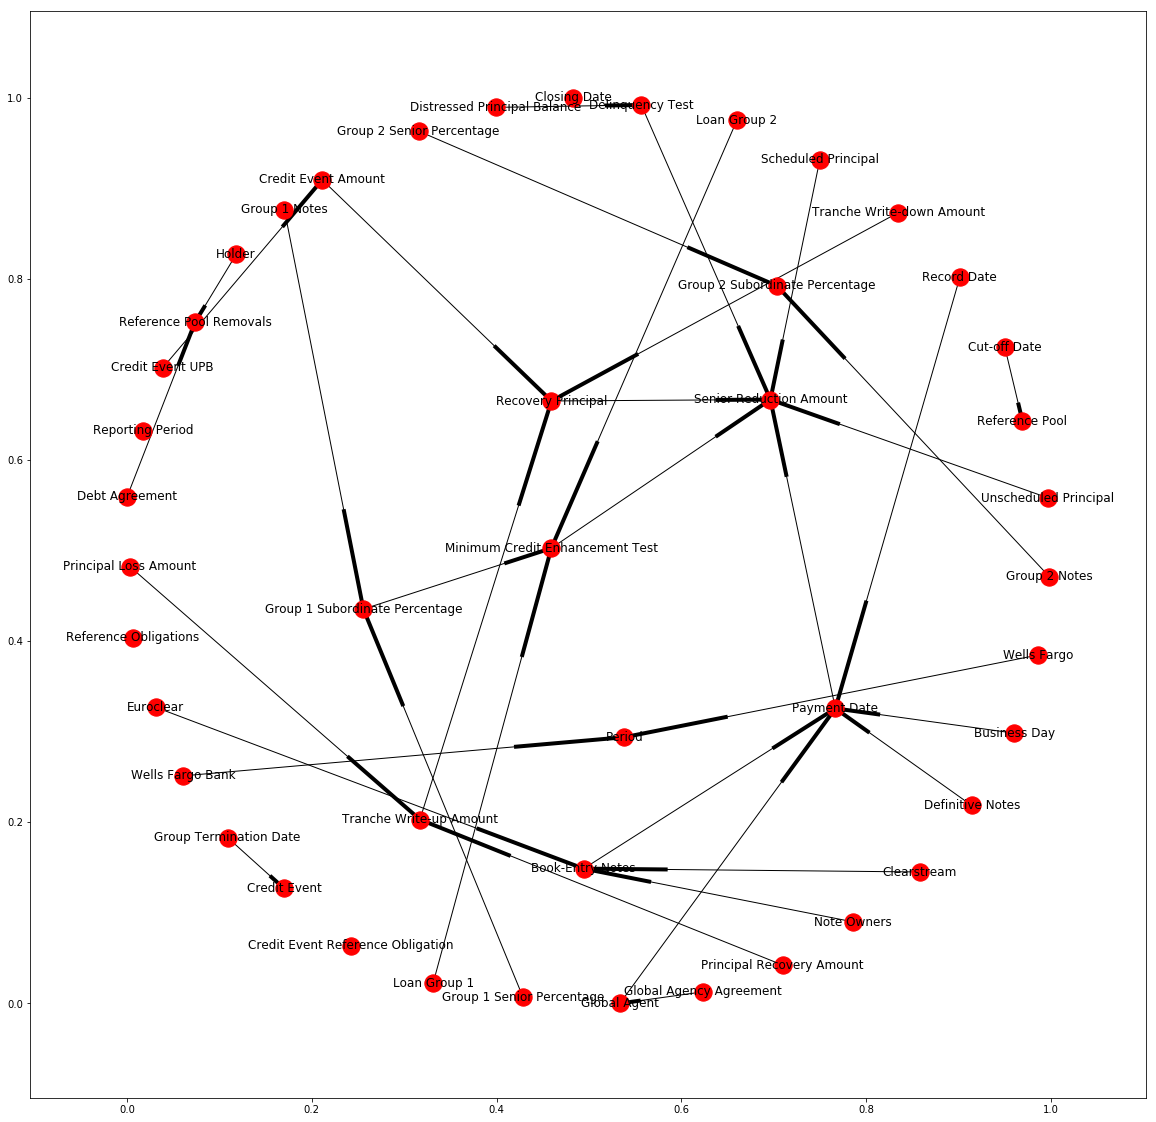

In [117]:
for edge in g2.in_edges('Scheduled Principal'):
    g2.remove_edge(*edge)
plt.figure(1,figsize=(20,20))
nx.draw_networkx(g2)
plt.show()